In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pickle

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [53]:
ROOT_DIR = '/content/gdrive/My Drive/Colab Projects/federated_and_cluster_based_energy_demand_prediction'
data_dir = os.path.join(ROOT_DIR, 'preprocessed_data')

output_dir = os.path.join(ROOT_DIR, 'output_visualization')
os.makedirs(output_dir, exist_ok=True)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
current_output_dir = os.path.join(output_dir, current_time)
os.makedirs(current_output_dir, exist_ok=True)

In [54]:
residential_cluster_dict = {-1:[11, 15, 20, 7],
                            # -1:[11, 15, 18, 20, 7],
                            0:[3, 5, 14], 
                            1:[4, 8, 9, 10, 13, 19], 
                            2:[6, 12]}


In [79]:
# residential_ids = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20]
residential_ids = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 19, 20]
time_range = ['2015-09-29','2017-09-29']

### Prepare data

In [80]:
residential_df_list = []

for residential_id in residential_ids:

    processed_data_file = os.path.join(data_dir, 'preprocessed_residential_{}.csv'.format(residential_id))
    residential_df = pd.read_csv(processed_data_file, 
                          parse_dates=['datetime'], 
                          infer_datetime_format=True, 
                          index_col='datetime', 
                          low_memory=False)
    
    residential_df_list.append(residential_df)

In [116]:
residential_df_dict = {}
for i, residential_id in enumerate(residential_ids):
    residential_df_dict[residential_id] = residential_df_list[i]

In [117]:
for residential_id in residential_ids:
    residential_df_dict[residential_id] = residential_df_dict[residential_id].resample('D').sum()

In [118]:
scaler = MinMaxScaler(feature_range=(0, 1)) # normalize features (0 ~ 1)

In [119]:
features = ['energy_kWh']
targets = ['energy_kWh']

In [120]:
for residential_id in residential_ids:
    residential_df = residential_df_dict[residential_id]
    residential_df[features] = scaler.fit_transform(residential_df[features])

In [121]:
start_date = time_range[0]
end_date =  time_range[1]

train_data_dict = {}
valid_data_dict = {}

for residential_id in residential_ids:
    residential_df = residential_df_dict[residential_id]
    train_data_dict[residential_id] = residential_df.loc[start_date:end_date]
    # valid_data_dict[residential_id] = residential_df.loc[end_date:]
    valid_data_dict[residential_id] = residential_df.loc[end_date:'2018-01-20']

### Prepare for evaluation

In [122]:
window_size = 30
ahead = 1

In [123]:
federated_model_path = os.path.join(ROOT_DIR, 'output', '20200525-031437_federated', 'federated_and_clustered_model_mae_0.1031.h5')
federated_model = tf.keras.models.load_model(federated_model_path)

cluster_0_model_path = os.path.join(ROOT_DIR, 'output', '20200520-021802_cluster_0', 'federated_and_clustered_model_mae_0.0856.h5')
cluster_0_model = tf.keras.models.load_model(cluster_0_model_path)

cluster_1_model_path = os.path.join(ROOT_DIR, 'output', '20200520-044547_cluster_1', 'federated_and_clustered_model_mae_0.1049.h5')
cluster_1_model = tf.keras.models.load_model(cluster_1_model_path)

cluster_2_model_path = os.path.join(ROOT_DIR, 'output', '20200521-024808_cluster_2', 'federated_and_clustered_model_mae_0.1309.h5')
cluster_2_model = tf.keras.models.load_model(cluster_2_model_path)

In [124]:
federated_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 30, 512)           528384    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 256)           656384    
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                491584    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

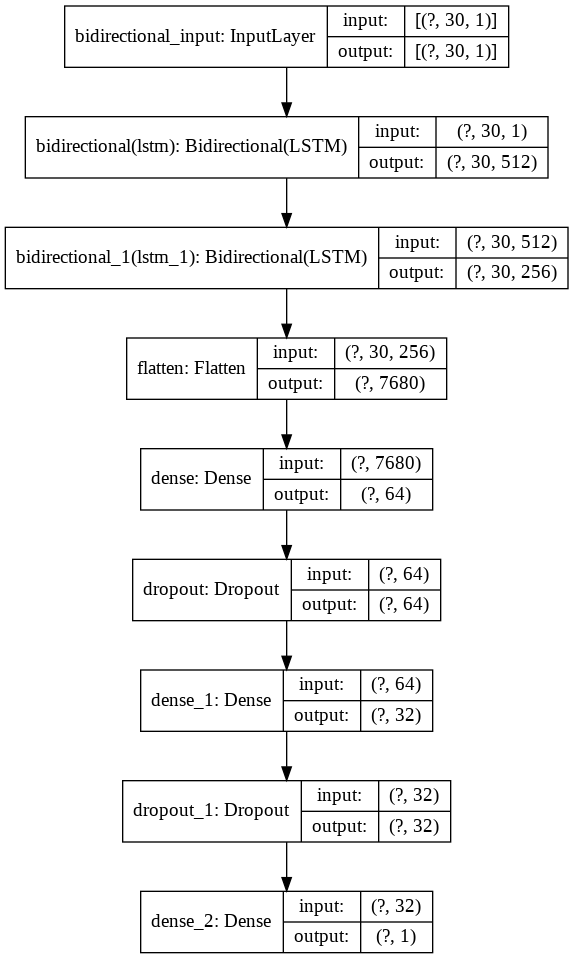

In [125]:
tf.keras.utils.plot_model(federated_model, show_shapes=True)

In [126]:
def window_dataset(series, window_size, ahead=1, batch_size=32, shuffle_buffer=1000): 

    # series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series.values)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-ahead], window[-ahead][0:len(targets)]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [127]:
def model_forecast(model, series, window_size):
    # series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series.values)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(32).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [128]:
windowed_valid_set_dict = {}
for residential_id in residential_ids:
    valid_data = valid_data_dict[residential_id] 
    windowed_valid_set_dict[residential_id] = window_dataset(valid_data, window_size, ahead)  

### Valid data patterns

In [129]:
def plot_valid_patterns(cluster_no):
    for residential_id in residential_cluster_dict[cluster_no]:
        valid_data = valid_data_dict[residential_id] 
        print(valid_data.shape)
        valid_data.plot(figsize=(0.1*valid_data.shape[0], 2), grid=True)

In [130]:
# cluster_no = 0
# plot_valid_patterns(cluster_no)

In [131]:
# cluster_no = 1
# plot_valid_patterns(cluster_no)

In [132]:
# cluster_no = 2
# plot_valid_patterns(cluster_no)

### Training history

In [133]:
model_names = ['Without Clustering', 'Cluster 0', 'Cluster 1', 'Cluster 2']
history_file_dirs = ['20200520-020818_federated', '20200520-021802_cluster_0', '20200520-044547_cluster_1', '20200521-024808_cluster_2']
figure_sizes = [(8,4), (4,3), (8,3), (4,3)]

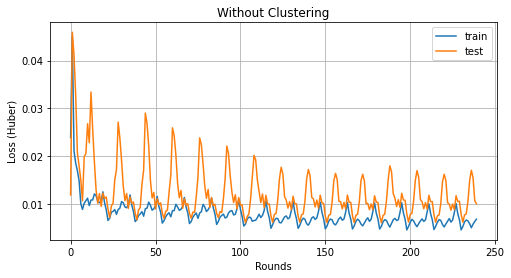

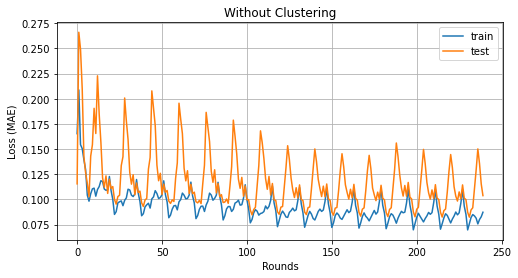

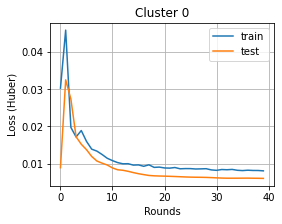

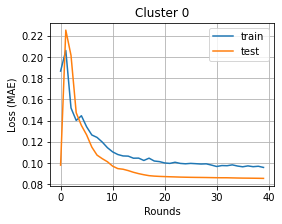

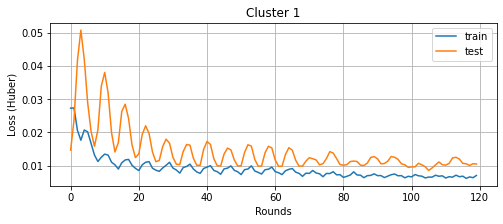

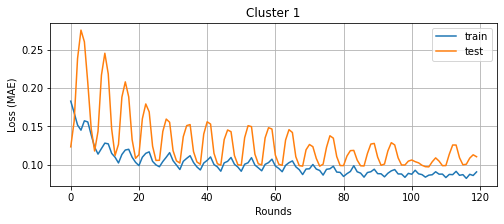

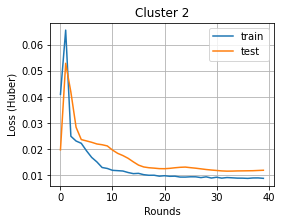

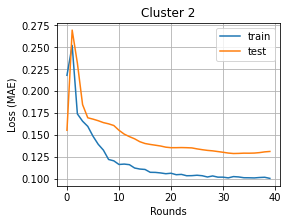

In [134]:
for model_name, history_file_dir, figure_size in zip(model_names, history_file_dirs, figure_sizes):
    
    training_history_file = os.path.join(ROOT_DIR, 'output', history_file_dir, 'training_history.txt')
    training_history = pickle.load(open(training_history_file, "rb"))
    train_mse, test_mse, train_mae, test_mae = training_history

    # Plot Huber
    plt.figure(figsize=figure_size)
    plt.plot(train_mse, label='train')
    plt.plot(test_mse.flatten(), label='test')
    plt.title(model_name)
    plt.xlabel('Rounds')
    plt.ylabel('Loss (Huber)')
    plt.grid(True)
    plt.legend()
    img_path = os.path.join(current_output_dir, 'huber_{}.png'.format(model_name))
    plt.savefig(img_path, dpi=300, bbox_inches = 'tight')
    plt.show()

    # Plot MAE
    plt.figure(figsize=figure_size)
    plt.plot(train_mae, label='train')
    plt.plot(test_mae, label='test')
    plt.title(model_name)
    plt.xlabel('Rounds')
    plt.ylabel('Loss (MAE)')
    plt.grid(True)
    plt.legend()
    img_path = os.path.join(current_output_dir, 'mae_{}.png'.format(model_name))
    plt.savefig(img_path, dpi=300, bbox_inches = 'tight')
    plt.show()

### Evaluation


In [135]:
metrics_dict = {}
cluster_models = [cluster_0_model, cluster_1_model, cluster_2_model]

In [136]:
def evaluate_model(cluster_no):
    for residential_id in residential_cluster_dict[cluster_no]:
        valid_set = windowed_valid_set_dict[residential_id]
        federated_metrics = federated_model.evaluate(valid_set)

        cluster_model = cluster_models[cluster_no]
        clustered_metrics = cluster_model.evaluate(valid_set)
        metrics_dict[residential_id] = {'federated_metrics':federated_metrics, 'clustered_metrics':clustered_metrics}


def print_evaluation(cluster_no):
    print('cluster: ', cluster_no)
    for residential_id in residential_cluster_dict[cluster_no]:
        metrics = metrics_dict[residential_id]
        
        print()
        print('residential_id: ', residential_id)
        print('federated_metrics :', metrics['federated_metrics'])
        print('clustered_metrics :', metrics['clustered_metrics'])


def plot_true_and_prediction(cluster_no):

    for residential_id in residential_cluster_dict[cluster_no]:

        cluster_model = cluster_models[cluster_no]

        valid_data = valid_data_dict[residential_id] 
        federated_forecast = model_forecast(federated_model, valid_data[:-1], window_size)[:,0]
        clustered_forecast = model_forecast(cluster_model, valid_data[:-1], window_size)[:,0]

        plt.figure(figsize=(0.12*federated_forecast.shape[0], 3))
        plt.plot(valid_data.index[window_size:], valid_data[targets][window_size:], label='true', marker='o')
        plt.plot(valid_data.index[window_size:], federated_forecast, label='Without Clustering', marker='*',linestyle = ':')
        plt.plot(valid_data.index[window_size:], clustered_forecast, label='Clustering', marker='*',linestyle = ':')
        plt.title('True Values and Predictions (Cluster {})'.format(cluster_no))
        plt.xlabel('Time-Slots')
        plt.ylabel('Normalized Values')
        plt.grid(True)
        plt.legend()
        img_path = os.path.join(current_output_dir, 'true_and_prediction_cluster_{}_client_{}.png'.format(cluster_no, residential_id))
        plt.savefig(img_path, dpi=300, bbox_inches = 'tight')
        plt.show()

In [137]:
cluster_no = 0
evaluate_model(cluster_no)

3/3 [==============================] - 0s 66ms/step - loss: 0.0056 - mean_absolute_error: 0.0834


In [138]:
print_evaluation(cluster_no)

cluster:  0

residential_id:  3
federated_metrics : [0.008879837580025196, 0.09894075989723206]
clustered_metrics : [0.008296936750411987, 0.10095082968473434]

residential_id:  5
federated_metrics : [0.005161111708730459, 0.07447324693202972]
clustered_metrics : [0.0050860000774264336, 0.07783469557762146]

residential_id:  14
federated_metrics : [0.005750501994043589, 0.08664270490407944]
clustered_metrics : [0.005577567499130964, 0.08335448801517487]


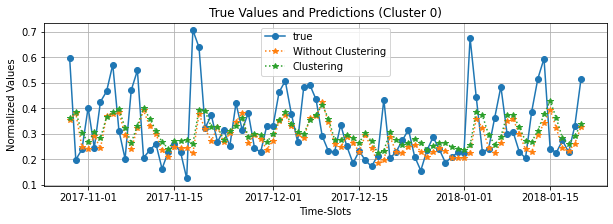

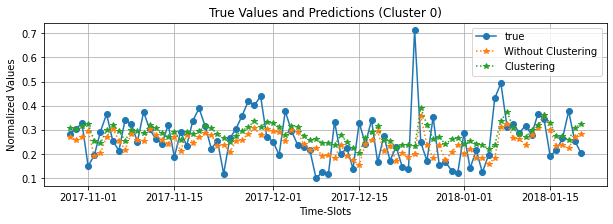

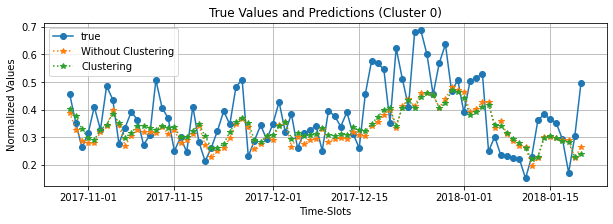

In [139]:
plot_true_and_prediction(cluster_no)

In [140]:
cluster_no = 1
evaluate_model(cluster_no)

3/3 [==============================] - 0s 72ms/step - loss: 0.0086 - mean_absolute_error: 0.1121


In [141]:
print_evaluation(cluster_no)

cluster:  1

residential_id:  4
federated_metrics : [0.012239447794854641, 0.1228725016117096]
clustered_metrics : [0.010459678247570992, 0.10924049466848373]

residential_id:  8
federated_metrics : [0.013015893287956715, 0.11634113639593124]
clustered_metrics : [0.013601167127490044, 0.11739806830883026]

residential_id:  9
federated_metrics : [0.012665797024965286, 0.10797981917858124]
clustered_metrics : [0.012206889688968658, 0.10801506042480469]

residential_id:  10
federated_metrics : [0.009489287622272968, 0.09480570256710052]
clustered_metrics : [0.009526853449642658, 0.09470421075820923]

residential_id:  13
federated_metrics : [0.01576114259660244, 0.12892138957977295]
clustered_metrics : [0.01519051007926464, 0.12562663853168488]

residential_id:  19
federated_metrics : [0.012970956973731518, 0.14490839838981628]
clustered_metrics : [0.008613974787294865, 0.11213232576847076]


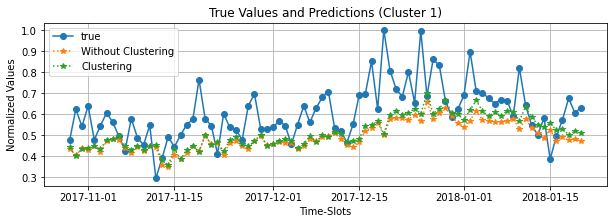

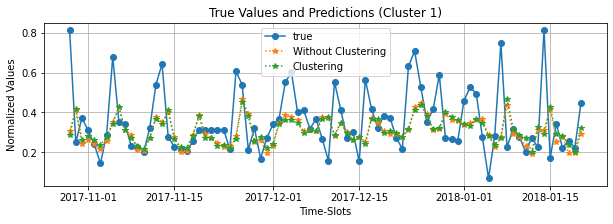

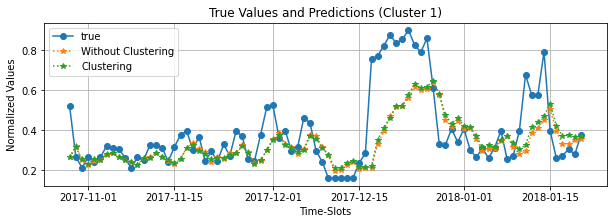

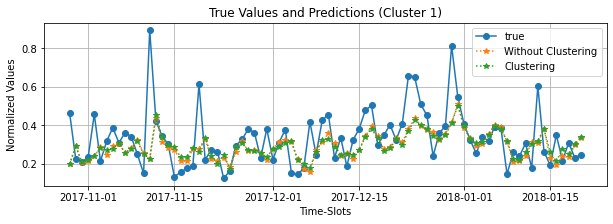

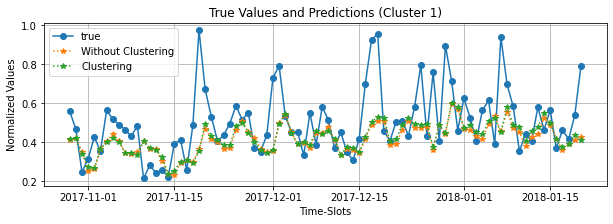

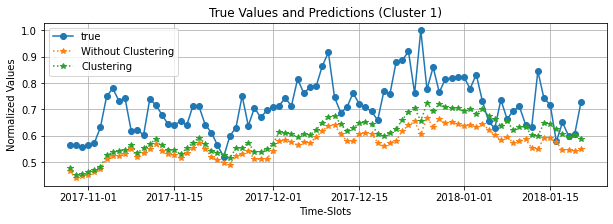

In [142]:
plot_true_and_prediction(cluster_no)

In [143]:
cluster_no = 2
evaluate_model(cluster_no)

3/3 [==============================] - 0s 64ms/step - loss: 0.0077 - mean_absolute_error: 0.1102


In [144]:
print_evaluation(cluster_no)

cluster:  2

residential_id:  6
federated_metrics : [0.014032329432666302, 0.13470375537872314]
clustered_metrics : [0.01798003911972046, 0.16173389554023743]

residential_id:  12
federated_metrics : [0.0051706270314753056, 0.07782167196273804]
clustered_metrics : [0.0077143339440226555, 0.11016987264156342]


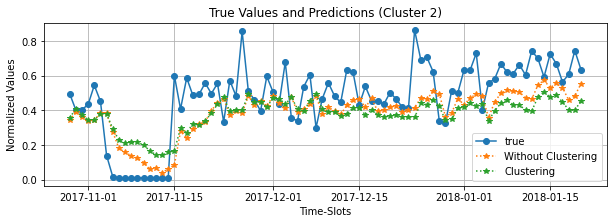

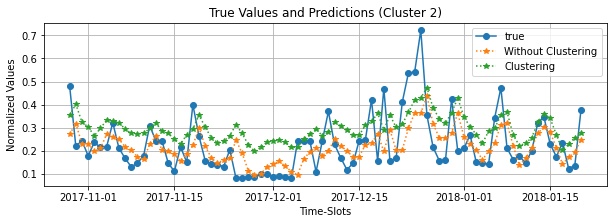

In [145]:
plot_true_and_prediction(cluster_no)

In [146]:
cluster_no = 0

train_data_all = []
valid_data_all = []

for residential_id in residential_cluster_dict[cluster_no]:
    train_data = train_data_dict[residential_id]
    valid_data = valid_data_dict[residential_id]
    
    for data in train_data.values:
        train_data_all.append(data[0])

    for data in valid_data.values:
        valid_data_all.append(data[0])

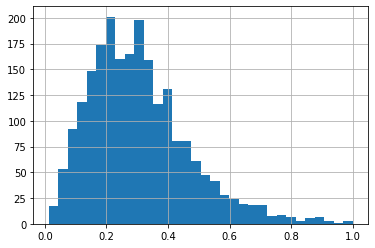

In [147]:
plt.hist(train_data_all, bins='auto')
plt.grid(True)
plt.show()

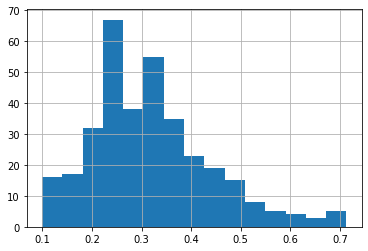

In [148]:
plt.hist(valid_data_all, bins='auto')
plt.grid(True)
plt.show()

In [149]:
print(len(train_data_all))

2196


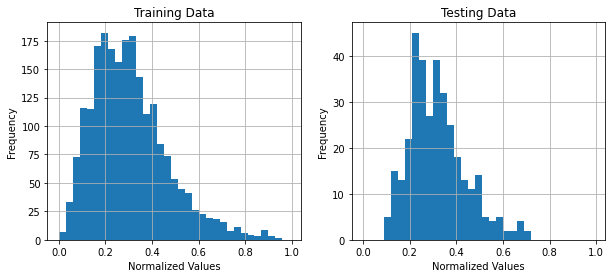

In [150]:
bins_list = np.arange(start=0.0, stop=1.0, step=0.03)

fig, a = plt.subplots(1,2, figsize=(10,4))

a[0].hist(train_data_all, bins=bins_list)
a[0].set_xlabel('Normalized Values')
a[0].set_ylabel('Frequency')
a[0].set_title('Training Data')
a[0].grid()

a[1].hist(valid_data_all, bins=bins_list)
a[1].set_xlabel('Normalized Values')
a[1].set_ylabel('Frequency')
a[1].set_title('Testing Data')
a[1].grid()

img_path = os.path.join(current_output_dir, 'train_and_test_histogram_cluster_{}.png'.format(cluster_no))
plt.savefig(img_path, dpi=300, bbox_inches = 'tight')

plt.show()



In [151]:
# valid_data_dict = {}

# for residential_id in residential_ids:
#     residential_df = residential_df_dict[residential_id]
#     valid_data_dict[residential_id] = residential_df.loc['2018-01-20':]

In [152]:

# def plot_true_and_prediction_single(cluster_no, residential_id):

#     cluster_model = cluster_models[cluster_no]

#     valid_data = valid_data_dict[residential_id] 
#     federated_forecast = model_forecast(federated_model, valid_data[:-1], window_size)[:,0]
#     clustered_forecast = model_forecast(cluster_model, valid_data[:-1], window_size)[:,0]

#     plt.figure(figsize=(0.12*federated_forecast.shape[0], 3))
#     plt.plot(valid_data.index[window_size:], valid_data[targets][window_size:], label='true', marker='o')
#     plt.plot(valid_data.index[window_size:], federated_forecast, label='Without Clustering', marker='*',linestyle = ':')
#     plt.plot(valid_data.index[window_size:], clustered_forecast, label='Clustering', marker='*',linestyle = ':')
#     plt.title('True Values and Predictions (Cluster {})'.format(cluster_no))
#     plt.xlabel('Time-Slots')
#     plt.ylabel('Normalized Values')
#     plt.grid(True)
#     plt.legend()
#     img_path = os.path.join(current_output_dir, 'true_and_prediction_cluster_{}_client_{}.png'.format(cluster_no, residential_id))
#     plt.savefig(img_path, dpi=300, bbox_inches = 'tight')
#     plt.show()